In [1]:
# 制作数据集
import sys
import os
root = "/data/public/renhaoye/morphics/"
subdirs = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
for subdir in subdirs:
    sys.path.append(subdir)

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import random
from torch.backends import cudnn
from dataset.galaxy_dataset import *
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Subset
from utils import schemas
from training import losses, metrics
import argparse
from utils.utils import *
from torchvision.models import *
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from models.morphics import Morphics
from torch.optim.lr_scheduler import ReduceLROnPlateau
from models.utils import *


In [3]:
img = torch.Tensor(load_img("/data/public/renhaoye/morphics/dataset/in_decals/agmtn/119.85429851358965_28.803799075693085.fits"))
# img = img.unsqueeze(0)
img.shape

torch.Size([3, 256, 256])

In [15]:
model = torch.load("/data/public/renhaoye/morphics/pth_stn/model_2.pt")

In [16]:
predict, stn= model(img.unsqueeze(0).to("cuda:1"))
fits.writeto(f'/data/public/renhaoye/1.fits', stn[0].cpu().detach().numpy(), overwrite=True)

In [13]:
predict

tensor([[ 0.0844,  1.2757, -1.5771, -1.3011,  1.3843,  0.9935, -0.6466, -0.7398,
          0.2088,  0.6360, -2.7871, -1.2049,  1.1606,  1.4957, -0.9135, -0.5932,
          1.0557, -0.6426, -1.2695, -0.1675,  0.6589,  0.4385,  0.0532, -0.5807,
         -1.2494,  1.3543, -0.2603, -1.5440, -1.6508,  0.6221,  1.2070,  0.1339,
         -0.6582, -0.8981]], device='cuda:1', grad_fn=<AddBackward0>)

In [14]:
question_answer_pairs = gz2_pairs
dependencies = gz2_and_decals_dependencies
schema = schemas.Schema(question_answer_pairs, dependencies)
predict = softmax_output(predict,schema.question_index_groups)
predict

tensor([[ 24.0690,  76.9310,   0.0000, 100.0000,   0.0000, 100.0000,   0.0000,
          28.6370,  72.3630,   0.0000,   1.7609,   4.7018,  40.4226,  56.1147,
           0.0000,  16.9647,  84.0353,   0.0000,  25.6856,  75.3144,   0.0000,
          59.9198,  41.0802,   0.0000,   6.3179,  72.8633,  15.2984,   4.9608,
           4.5596,   0.0000,  67.1409,  23.6164,  11.2427,   0.0000]],
       device='cuda:1', grad_fn=<CopySlices>)

In [10]:
pred_mnist, epi_mnist_norm, ale_mnist_norm = get_uncertainty_per_image(model, img.cuda(), T=10, normalized=True)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument weight in method wrapper_CUDA__cudnn_convolution)

In [18]:
pred_mnist

array([ 6.1986589e-01,  2.0184496e-01, -1.4715673e+00, -7.7971363e-01,
        6.9392610e-01,  2.2599626e-01, -2.0834167e-01, -9.6987319e-01,
       -1.1796487e-01,  8.3403474e-01, -2.5028355e+00, -5.7288098e-01,
        9.3109423e-01,  7.5418860e-01, -1.1366481e+00,  1.2420118e-04,
        5.2260745e-01, -8.3282900e-01, -1.1405461e+00, -3.4915301e-01,
        1.0287037e+00,  4.4249696e-01,  1.6260603e-01, -3.6677971e-01,
       -1.1561434e+00,  1.3320980e+00, -4.6493351e-01, -1.6384544e+00,
       -2.6482787e+00,  4.7209993e-01,  1.4303304e+00, -4.2549528e-02,
       -1.3607514e+00, -1.2942281e+00], dtype=float32)

In [19]:
question_answer_pairs = gz2_pairs
dependencies = gz2_and_decals_dependencies
schema = schemas.Schema(question_answer_pairs, dependencies)
pred_mnist = softmax_output(torch.Tensor(pred_mnist,schema.question_index_groups)
pred_mnist

tensor([ 60.6979,  40.3021,   0.0000, 100.0000,   0.0000, 100.0000,   0.0000,
         30.6042,  70.3958,   0.0000,   2.5264,  11.5155,  48.3149,  40.6432,
          0.0000,  37.8549,  63.1451,   0.0000,  31.8751,  69.1249,   0.0000,
         57.3824,  43.6176,   0.0000,   7.2349,  76.0683,  13.4456,   4.8491,
          2.4022,   0.0000,  77.7074,  18.5863,   5.7064,   0.0000])

array([1.7033335e-08, 1.6753219e-07, 5.5029257e-09, 1.5647780e-07,
       3.2251464e-08, 1.8313497e-07, 1.7248030e-07, 2.9690239e-07,
       2.4569706e-06, 1.7428664e-07, 2.0172670e-06, 5.1425877e-13,
       2.9239136e-08, 5.5045973e-08, 1.0053172e-07, 2.4659010e-07,
       2.0776032e-08, 1.0866687e-08, 3.7976289e-08, 3.5593781e-09,
       1.1430995e-08, 1.6909146e-06, 2.3880619e-07, 1.8421627e-08,
       9.2632142e-08, 1.3757867e-07, 8.0269942e-08, 3.5363635e-06,
       8.3060506e-08, 9.3242562e-08, 1.9771420e-07, 4.2517727e-09,
       4.4667114e-08, 1.7839776e-08], dtype=float32)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image

class NonLinearTransform(nn.Module):
    def __init__(self, hidden_size):
        super(NonLinearTransform, self).__init__()
        self.hidden_size = hidden_size
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.mlp = nn.Sequential(
            nn.Linear(64 * 56 * 56, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 256)
        )

    def forward(self, x):
        # 使用特征提取器提取特征
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)

        # 使用 MLP 学习非线性变换函数参数
        transform_params = self.mlp(features)
        transform_params = transform_params.view(-1, 256)

        # 对图像的灰度值进行非线性变换
        transformed_x = torch.matmul(x.view(x.size(0), -1), transform_params)
        transformed_x = transformed_x.view(x.size())

        return transformed_x

In [16]:

# 载入示例图像并转换为tensor
image = Image.open("/data/public/renhaoye/example.jpg").convert('L')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)

# 创建一个非线性变换网络
non_linear_transform = NonLinearTransform(hidden_size=3)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(non_linear_transform.parameters(), lr=0.001)

# 训练非线性变换网络
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # 对输入图像应用非线性变换
    transformed_image_tensor = non_linear_transform(image_tensor)

    # 计算损失
    loss = criterion(transformed_image_tensor, image_tensor)

    # 反向传播和优化
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# 将变换后的图像tensor转换为PIL图像并显示
transformed_image = transforms.ToPILImage()(transformed_image_tensor.squeeze(0))
transformed_image.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x50176 and 1x256)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.show()

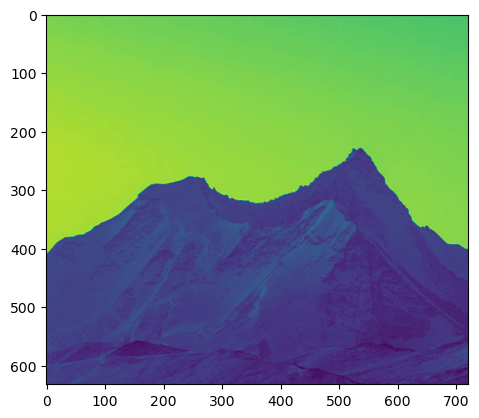

In [14]:
plt.imshow(image)